In [14]:
import time
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from simple_pe.waveforms import calculate_mode_snr, make_waveform, two_ecc_harms_SNR, generate_eccentric_waveform_MA
from simple_pe.param_est import find_peak_snr
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from pycbc import psd as psd_func
from pycbc.filter import sigma, matched_filter, match
from pycbc.filter.matchedfilter import quadratic_interpolate_peak

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Match along degeneracy line fluctuations for full wf and different harmonics

In [2]:
# Degeneracy line settings
base_dict = {'chirp_mass': 24.544669678101315, 'symmetric_mass_ratio': 0.22954481062897308, 'chi_eff': 0.03176258422490982, 'ecc10sqrd': 0}
fid_dict = {'ecc10sqrd': 0.006866362016958059, 'chirp_mass': 24.505135697013156, 'symmetric_mass_ratio': 0.22968526336432, 'chi_eff': 0.029215006254547496}

def degen_line(e):
    param_dist = (e**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    degen_dict = {}
    for key in base_dict.keys():
        degen_dict[key] = param_dist*(fid_dict[key]-base_dict[key])+base_dict[key]
    return degen_dict

In [3]:
# Data settings
true_dict = degen_line(0.2)
target_snr = 20
t_bounds = [-0.05,0.05]
f_low = 20
sample_rate = 4096
tlen = 32
print(f'Analysing data with SNR of {target_snr}.')
print(true_dict)

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

Analysing data with SNR of 20.
{'chirp_mass': 24.314364424806946, 'symmetric_mass_ratio': 0.2303630182038142, 'chi_eff': 0.01692166576433056, 'ecc10sqrd': 0.04000000000000001}


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


31 complete out of 31

Text(0, 0.5, 'match')

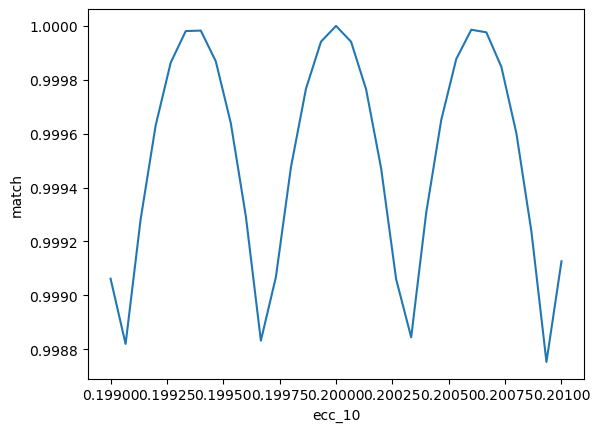

In [4]:
# Test matches along degen line with full ecc wf
eccs = np.linspace(0.199, 0.201, 31)
ms = []
for i, ecc in enumerate(eccs):
    trial_dict = degen_line(ecc)
    trial_wf = make_waveform(trial_dict, psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
    m, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low)
    ms.append(m)
    print(f'\r{i+1} complete out of {len(eccs)}', end='')

# Plot
plt.plot(eccs, ms)
plt.xlabel('ecc_10')
plt.ylabel('match')

31 complete out of 31

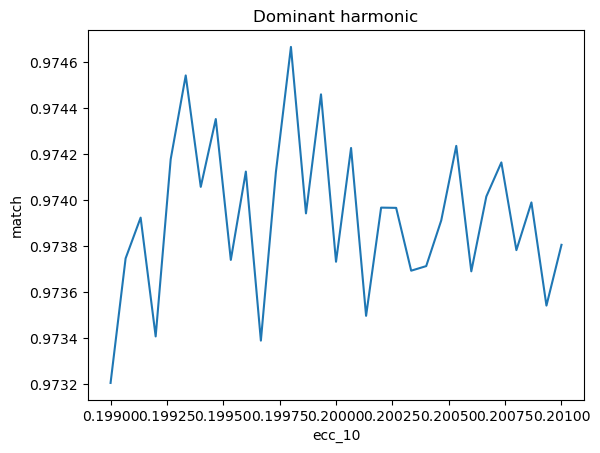

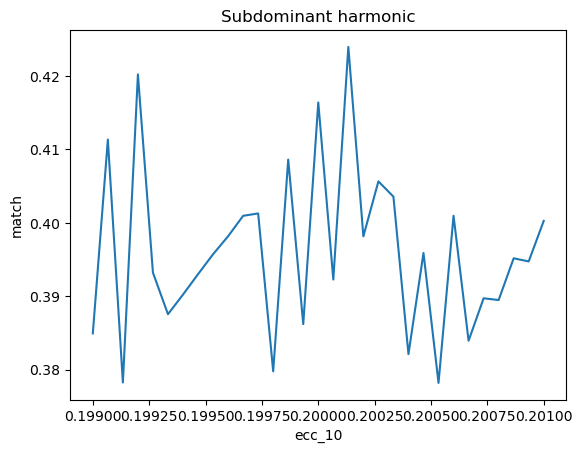

In [5]:
# Repeat with dominant and subdominant harmonics
eccs = np.linspace(0.199, 0.201, 31)
m0s = []
m1s = []
for i, ecc in enumerate(eccs):
    trial_dict = degen_line(ecc)
    trial_harms = make_waveform(trial_dict, psd['harm'].delta_f, f_low, len(psd['harm']),
                                approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    m0, _ = match(data['H1'], trial_harms[0], psd=psd['H1'], low_frequency_cutoff=f_low)
    m1, _ = match(data['H1'], trial_harms[1], psd=psd['H1'], low_frequency_cutoff=f_low)
    m0s.append(m0)
    m1s.append(m1)
    print(f'\r{i+1} complete out of {len(eccs)}', end='')

# Plot
plt.plot(eccs, m0s)
plt.xlabel('ecc_10')
plt.ylabel('match')
plt.title('Dominant harmonic')
plt.show()

# Plot
plt.plot(eccs, m1s)
plt.xlabel('ecc_10')
plt.ylabel('match')
plt.title('Subdominant harmonic')
plt.show()

We see similar fluctuations in match between full wf and dominant harmonic.

# Trying additional 3d steps at end of peak finder

We now look at how the peak finder works with different methods, percentage differences from true values tabled below:

| Method | ecc10sqrd | chirp_mass | symmetric_mass_ratio | chi_eff | peak SNR |
| --- | --- | --- | --- | --- | --- |
| non-ecc peak then degen line | -1.87% | 1.33% | 3.66% | 1.72% | 19.972 |
| adding final 3d step with dominant harmonic | -1.87% | 3.09% | 7.41% | 4.9% | 0.018 |
| adding final 3d step with generate_eccentric_waveform_MA() | -1.87% | 1.49% | 3.55% | 1.75% | 19.981 |

Obviously with disclaimer this is just for one example/datapoint.

In [3]:
# Data settings
true_dict = {'ecc10sqrd': 0.04000000000000001, 'chirp_mass': 24, 'symmetric_mass_ratio': 0.2222222222222222, 'chi_eff': 0}
target_snr = 20
t_bounds = [-0.05,0.05]
f_low = 20
sample_rate = 4096
tlen = 32
print(f'Analysing data with SNR of {target_snr}.')
print(true_dict)

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

Analysing data with SNR of 20.
{'ecc10sqrd': 0.04000000000000001, 'chirp_mass': 24, 'symmetric_mass_ratio': 0.2222222222222222, 'chi_eff': 0}


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


In [7]:
current_dict = {'ecc10sqrd': 0.03925201, 'chirp_mass': 24.31867105, 'symmetric_mass_ratio': 0.23034772, 'chi_eff': 0.01719919}
string = '|'
for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    if key == 'chi_eff':
        denom = 1
    else:
        denom = true_dict[key]
    print(key, f'{(current_dict[key]-true_dict[key])*100/denom:.3g}%')
    string += f' {(current_dict[key]-true_dict[key])*100/denom:.3g}% |'
print(string)

ecc10sqrd -1.87%
chirp_mass 1.33%
symmetric_mass_ratio 3.66%
chi_eff 1.72%
| -1.87% | 1.33% | 3.66% | 1.72% |


In [8]:
# Find peak SNR
start = time.time()
t_start, t_end = t_bounds
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
bounds = [(22,26), (0.22,0.24), (-0.05,0.05)]
init_guess = {'ecc10sqrd': 0.03925201, 'chirp_mass': 24.31867105, 'symmetric_mass_ratio': 0.23034772, 'chi_eff': 0.01719919}
peak_dict, snr = find_peak_snr(ifos, data, psd, t_start, t_end, init_guess, dx_directions, f_low,
                               bounds=bounds, approximant="TEOBResumS-Dali-Harms", method='scipy')
base_dict = {key: peak_dict[key] for key in dx_directions}
base_dict['ecc10sqrd'] = init_guess['ecc10sqrd']
end = time.time()
print(f'Peak SNR of {snr} found in {end-start} seconds.')
print(base_dict)

string = '|'
for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    if key == 'chi_eff':
        denom = 1
    else:
        denom = true_dict[key]
    print(key, f'{(base_dict[key]-true_dict[key])*100/denom:.3g}%')
    string += f' {(base_dict[key]-true_dict[key])*100/denom:.3g}% |'
print(string)

Peak SNR of 0.018872005205826926 found in 791.6625218391418 seconds.
{'chirp_mass': 24.740646032129668, 'symmetric_mass_ratio': 0.23867882646489702, 'chi_eff': 0.049027613836100825, 'ecc10sqrd': 0.03925201}
ecc10sqrd -1.87%
chirp_mass 3.09%
symmetric_mass_ratio 7.41%
chi_eff 4.9%
| -1.87% | 3.09% | 7.41% | 4.9% |


In [4]:
def test_ecc_point(vary_params, vary_keys, data, fixed_params, ecc_harms, target_MA, f_low, psd, two_ecc_harms=True):

    # Read in parameters
    params = fixed_params.copy()
    for i, key in enumerate(vary_keys):
        params[key] = vary_params[i]
    
    # Create  trial waveform
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_snr = matched_filter(trial_wf, data, psd, low_frequency_cutoff=f_low,
                              high_frequency_cutoff=psd.sample_frequencies[-1])
    maxsnr, max_id = data_snr.abs_max_loc()
    left = abs(data_snr[-1]) if max_id == 0 else abs(data_snr[max_id - 1])
    right = abs(data_snr[0]) if max_id == (len(data_snr) - 1) else abs(data_snr[max_id + 1])
    _, maxsnr = quadratic_interpolate_peak(left, maxsnr, right)

    return -maxsnr

In [5]:
# Find peak SNR
start = time.time()
t_start, t_end = t_bounds
dx_directions = ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
bounds = [(22,26), (0.22,0.24), (-0.05,0.05)]
# dx_directions = ['chirp_mass']
# bounds = [(22,26)]
init_guess = {'ecc10sqrd': 0.03925201, 'chirp_mass': 24.31867105, 'symmetric_mass_ratio': 0.23034772, 'chi_eff': 0.01719919}
# init_guess = {'ecc10sqrd': 0.03925201, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
ecc_harms = make_waveform(init_guess.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
mode_SNRs, _ = calculate_mode_snr(data['H1'], psd['H1'], ecc_harms, data['H1'].sample_times[0],
                                  data['H1'].sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
_, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                 {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
x0 = [init_guess[key] for key in dx_directions]
fixed_dict = {key: init_guess[key] for key in init_guess.keys() if key not in dx_directions}
best_result = optimize.minimize(test_ecc_point, x0, args=(dx_directions, data['H1'], fixed_dict, ecc_harms, target_MA,
                                                          f_low, psd['H1'], True),
                                bounds=bounds, method='Powell')
peak_dict = fixed_dict.copy()
for i, key in enumerate(dx_directions):
    peak_dict[key] = best_result['x'][i]
end = time.time()
print(f'Peak SNR of {-best_result["fun"]} found in {end-start} seconds.')
print(peak_dict)

string = '|'
for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    if key == 'chi_eff':
        denom = 1
    else:
        denom = true_dict[key]
    print(key, f'{(peak_dict[key]-true_dict[key])*100/denom:.3g}%')
    string += f' {(peak_dict[key]-true_dict[key])*100/denom:.3g}% |'
print(string)

Peak SNR of 19.981882787986056 found in 485.1728217601776 seconds.
{'ecc10sqrd': 0.03925201, 'chirp_mass': 24.3473402050095, 'symmetric_mass_ratio': 0.22964034789675164, 'chi_eff': 0.017369873467050913}
ecc10sqrd -1.87%
chirp_mass 1.45%
symmetric_mass_ratio 3.34%
chi_eff 1.74%
| -1.87% | 1.45% | 3.34% | 1.74% |


In [17]:
test_ecc_point([0.03925201], ['ecc10sqrd'], data['H1'], true_dict, ecc_harms, target_MA, f_low, psd['H1'], two_ecc_harms=True)

-19.997608151433617

# Plotting match against parameters in 1d

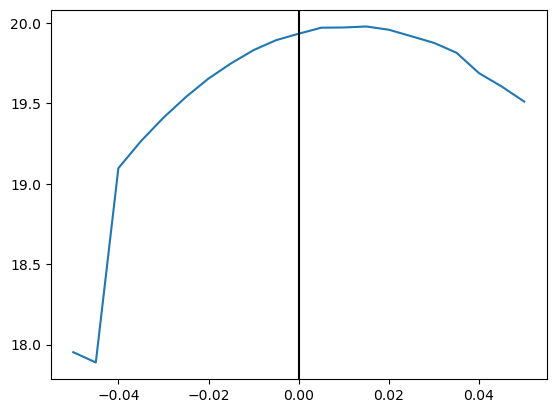

In [10]:
test_dict = init_guess.copy()
test_dict.pop('chi_eff')

chis = np.linspace(-0.05, 0.05, 21)
snrs = []
for chi in chis:
    snr = -test_ecc_point([chi], ['chi_eff'], data['H1'], test_dict, ecc_harms, target_MA, f_low, psd['H1'], two_ecc_harms=True)
    snrs.append(snr)
plt.plot(chis, snrs)
plt.axvline(true_dict['chi_eff'], c='k')
plt.show()

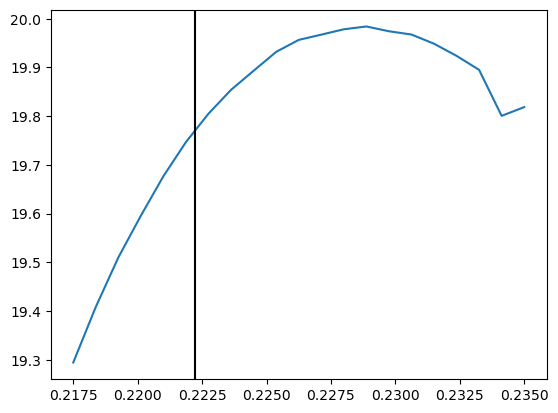

In [12]:
test_dict = init_guess.copy()
test_dict.pop('symmetric_mass_ratio')

etas = np.linspace(0.2175, 0.235, 21)
snrs = []
for eta in etas:
    snr = -test_ecc_point([eta], ['symmetric_mass_ratio'], data['H1'], test_dict, ecc_harms, target_MA, f_low, psd['H1'], two_ecc_harms=True)
    snrs.append(snr)
plt.plot(etas, snrs)
plt.axvline(true_dict['symmetric_mass_ratio'], c='k')
plt.show()

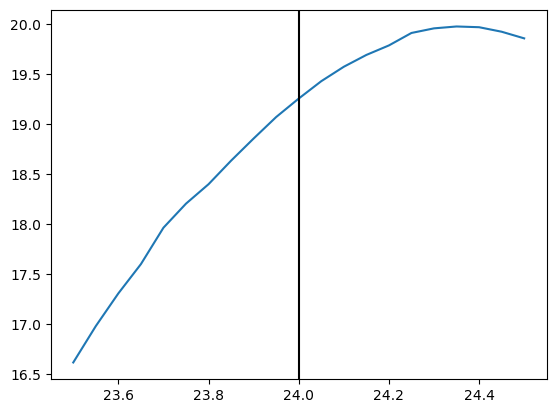

In [13]:
test_dict = init_guess.copy()
test_dict.pop('chirp_mass')

chirps = np.linspace(23.5, 24.5, 21)
snrs = []
for chirp in chirps:
    snr = -test_ecc_point([chirp], ['chirp_mass'], data['H1'], test_dict, ecc_harms, target_MA, f_low, psd['H1'], two_ecc_harms=True)
    snrs.append(snr)
plt.plot(chirps, snrs)
plt.axvline(true_dict['chirp_mass'], c='k')
plt.show()

# Plotting match against eigenvector directions of initial metric

In [15]:
with open(os.path.join('pe_4d_pipeline', 'dataslot_19', 'peak_info'), 'rb') as fp:
    peak_info = pickle.load(fp)
initial_metric = peak_info['initial_metric']
with open(os.path.join('pe_4d_pipeline', 'dataslot_19', 'samples_info'), 'rb') as fp:
    samples_info = pickle.load(fp)
peak_metric = samples_info['peak_metric']

In [27]:
def snr_against_evs(metric):

    # Remove eccentricity from metric and find eigenvectors
    dx_dirs = metric.dx_directions
    eccind = metric.dx_directions.index('ecc10sqrd')
    dx_dirs.remove('ecc10sqrd')
    nonecc_metric = metric.metric.copy()
    nonecc_metric = np.delete(nonecc_metric, eccind, axis=0)
    nonecc_metric = np.delete(nonecc_metric, eccind, axis=1)
    _, evs = np.linalg.eig(nonecc_metric)

    print(nonecc_metric, evs)

In [24]:
initial_metric.metric
intial_

array([[  6.53573142,   1.10758124, -28.44113278,  -7.88659382],
       [  1.10758124,   0.26685187,  -6.92647462,  -1.96111408],
       [-28.44113278,  -6.92647462, 193.62551969,  53.341041  ],
       [ -7.88659382,  -1.96111408,  53.341041  ,  15.37796372]])

In [29]:
snr_against_evs(initial_metric)

[[  0.26685187  -6.92647462  -1.96111408]
 [ -6.92647462 193.62551969  53.341041  ]
 [ -1.96111408  53.341041    15.37796372]] [[ 0.0345299  -0.99678465 -0.07230529]
 [-0.9632848  -0.01392035 -0.26812051]
 [-0.2662519  -0.07890876  0.96066817]]
